## Understanding Loop Dataset
This notebook tries provides details on the structure of the Loop dataset and makes suggestions how to process the data.

## The Loop study

**Title**: An Observational Study of Individuals with Type 1 Diabetes Using the Loop System for Automated Insulin Delivery: The Loop Observational Study (LOS)


**Description**: Passive data collection to collect data on the efficacy, safety, usability, and quality of life/ psychosocial effects of the Loop System
    
**Devices**: insulin pump and a Dexcom or Medtronic CGM

**Study Population**: People of any age with Type 1 Diabetes

## Checklist Template
- [x] Things to check in every dataset
0. [ ] Data
	1. [ ] Glossary
		1. [ ] List all relevant files and columns
			1. [ ] check if exist
			2. [ ] Check if there are more column names
			3. [ ] Are there other files, not mentioned?
	2. [ ] Missing data
		1. [ ] Check for null values
	3. [ ] Handle Duplicated Rows (overall)
		1. [ ] Duplicates on special columns (e.g. patient id, datetime)
			1. [ ] How often?
				1. [ ] If often investigate?  Check for correlation (e.g. CGM dups)
				2. [ ] Drop (keep max (`test_get_duplicated_max_indexes`), sum, first?)
	4. [ ] Incomplete Patients
		1. [ ] Keep only patients with data in all datasets (`total_ids = reduce(np.intersect1d, (df_basal.PtID.unique(), df_bolus.PtID.unique(), df_cgm.PtID.unique()))`)
2. [ ] Datetime Strings
	1. [ ] Datetestrings consistent?
		1. [ ] If not, check how to parse it efficiently and correctly. Use `parse_flair_dates` if applicable
	2. [ ] Adjustments made?
		1. [ ] Which one to use?
		2. [ ] Check if adjustments make sense 
			1. [ ] Visually inspect gaps (sample)
			2. [ ] Check summary statistics (do gaps get smaller?)
3. [ ] Timestamps
	1. [ ] All in local time?
		1. [ ] Glossary mentions UTC, timezones?
	2. [ ] Check distributions
		1. [ ] brekfast, lunch dinner peaks? 
		2. [ ] Data consistent with bolus and CGM?
4. [ ] CGMS
	1. [ ] Special Numbers
		1. [ ] Replaced?
5. [ ] Boluses
	1. [ ] Requested vs. Delivered (check what timestamp means)
	2. [ ] Extended bolus part duration
6. [ ] Basals
	1. [ ] Suspends?
	2. [ ] Temporary Basals

### Data
The study data folder is named **Loop study public dataset 2023-01-31**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

| File Name                     | Description                               | Note                                                                                           |
|-------------------------------|-------------------------------------------|-----------------------------------------------------------------------------------------------|
| **LOOPDeviceBasal<i>.txt**    | i=1-3, basal data exported from Tidepool | 3 files: 2.9GB, 2.9GB, and 1.35GB                                                             |
| **LOOPDeviceCGM<i>.txt**      | i=1-6, CGM data exported from Tidepool   | 6 files: 2.14GB, 2.24GB, 2.3GB, 2.31GB, 2.33GB, and 1.53GB.  Contains more patient IDs than Basal and Bolus files |
| **LOOPDeviceBolus.txt**       | Bolus data exported from Tidepool        | 1 file: 349MB                                                                                 |
| **PtRoster.txt**              | Patient Roster                           | Contains fixed UTC offsets which we need                                                     |

### Relevant Columns:
The following lists all relevant columns. Other columns were considered irrelevant. Some are still mentioned if they serve the discussion but crossed through.

#### LOOPDeviceCGM1-6
| Field_Name | Description | Note |
|----|----|-|
| **UTCDtTm** | Device date and time adjusted with timezone offset| These are UTC, the description is misleading! *1 |
| **RecordType**| Type of data (CGM, Calibration, etc)| Needed to drop calibrations|
| **CGMVal**| Glucose reading from the CGM (in mmol/L from Tidepool)| Convert to convert to mg/dl|
| ~~DeviceDtTm~~| Local device date and time; note not present in most rows because unavailable in Tidepool data source | *1 |
| ~~TmZnOffset~~| Timezone offset | *1 | 
| ~~Units~~ | Glucose reading units | all CGMs are in mmol/| 


#### LOOPDeviceBasal1-3

| Field Name | Glossary Description| Notes |
|-|-|-|
|**PtID**| Patient ID| Was not mentioned in glossary|
| **UTCDtTm**| Date and time with timezone offset| *1|
| **Rate** | Number of units per hour| **This is likely the only relevant value here**|
| ~~DeviceDtTm~~ | ~~Local device date and time; note not present in most rows because unavailable in Tidepool data source~~ |*1|
| ~~TmZnOffset~~ | ~~Timezone offset~~ | *1 | 
| BasalType| Basal delivery type | Unclear|
| Duration | Actual number of milliseconds basal will be in effect | Unclear |
| ExpectedDuration | Expected number of milliseconds basal will be in effect | Unclear|
| Percnt | Percentage of suppressed basal that should be delivered | Unclear|
| SuprBasalType| Suppressed basal delivery type (suppressed basal = basal event not being delivered because this one is active) | Unclear, Ambiguous description. JAEB did not use these values (see Q&A with JAEB below) |
| SuprDuration | Suppressed duration |Unclear|
| SuprRate | Suppressed rate | Unclear|

Example (first row):  
| PtID   | UTCDtTm| **BasalType** | Duration | ExpectedDuration | Percnt | Rate  | **SuprBasalType** | SuprDuration | SuprRate | TmZnOffset | 
|---|---|---|---|---|---|---|---|---|---|---|
| 1082 | 2018-05-29 10:02:56| **temp**| 244000   ||| 1.475 | **scheduled**|| 1.600|| 


#### LOOPDeviceBolus
| Field_Name| Description | Note |
|-|-|-|
| **UTCDtTm**| Device date and time (with timezone offset) |*1|
| **BolusType**| Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)||
| **Normal** | Number of units of normal bolus |Likely the only relevant value.|
| ~~DeviceDtTm~~ | Local device date and time; note not present in most rows because unavailable in Tidepool data source |*1|
| ~~TmZnOffset~~ | Timezone offset |*1|
| ExpectedNormal | Expected number of units of normal bolus|Unclear|
| Extended | Number of units for extended delivery | We found that there are 0.4% extended boluses, probably triggered from the pump directly since Loop does not support these.|
| ExpectedExtended | Expected number of units for extended delivery|
| Duration | Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data) | Our analysis shows that Duration refers to the Extended part of a Bolus. However, unclear how to find out wether in ms or minutes. JAEB couldn't answer.|
| ExpectedDuration | Expected time span over which the bolus should have been delivered (milliseconds for Tidepool data, minutes for Diasend data) |

We asked JAEB:

**Suppressed Deliveries:** What are suppressed deliveries in the context of basal data?    
> Answer: **We do not know** what the suppressed deliveries represent in this context, and we did not use this information for our analyses.  We calculated TDI using the Rate and Duration variables.  We suggest reaching out to Tidepool for information on suppressed deliveries.

**Patient IDs Discrepancy:** Why are there more patient IDs in the CGM files than in the Basal and Bolus files?  
> If available, CGM data from the participant’s personal CGM was collected for the 3 months prior to enrollment. A number of participants provided the retrospective personal CGM data but did not use Loop/provide us with their Loop data.

**Time Zones:** The UTCDtTm field does not include timezone information and TmZnOffset is only available when DeviceDtTm exists, which is rare. Local time might need to be extrapolated using backward / forward filling or using PtTimezoneOffset of the patient roster, which may not be reliable over long periods. How can local times be obtained for all patients, given the limited availability of DeviceDtTm and the potential inaccuracy of PtTimezoneOffset? 
>When we did the analysis, we used participant zip codes to estimate a local time. However, the zip code is not available in the public dataset. Instead, the variable PTTimezoneOffset in the PtRoster dataset can be applied to all UTC times to obtain a local time. During daylight savings, the offset should be reduced by 1.  This won’t be a perfect measure of the local time but should be a close approximation.

**Dexcom Times:** Are Dexcom DexInternalDtTm times in local time or UTC?  
> We did not use this variable because it is missing for the majority of cases.  We believe that it was only available in downloads from personal CGMs but not available in the data uploaded by Tidepool.  It may be the local time but may need to reach out to Dexcom to confirm this.

**Data Source Identification:** How can we determine if the data is uploaded from Tidepool or Diasend, especially since this affects the interpretation of extended boluses?  
> In most cases (perhaps all), Tidepool uploads are indicated by the OriginName field being equal to ‘.com.apple.HealthKit’.  However, we suggest reaching out to Tidepool as there might be scenarios where Diasend was involved in the data chain.

 - [1]:DeviceDtTm and TmZnOffset are only available for a fraction of patients. Therefore, we rely on UTCDtTm and patient roster PtTimezoneOffset to obtain local time. 
 - [2]: Loop has no extended boluses, check what this is

### Todos:  
Boluses:  
 - Need to check if the Normal portion is the actual delivered by comparing the values (<= in all cases would prove this to be true).
 - Check if there are extended boluses
 - Can we determine the delivery duration (ms or minutes) based on the data source?
Basals:
 - Need to double check if the Suppressed values are already factored in and if standard basal rates are reported as well.
 - Check potential values for columns like basal type (value-counts)


## Import

In [95]:
import os, sys
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
from dask import dataframe as dd

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from src import postprocessing

In [96]:
#define path variables
study_name = 'Loop study public dataset 2023-01-31'
raw_path = os.path.join(os.getcwd(), '..', 'data', 'raw')
out_path = os.path.join(os.getcwd(), '..', 'data', 'out')
loop_path = os.path.join(raw_path, study_name)
df_patient= pd.read_csv(os.path.join(loop_path, 'Data Tables', 'PtRoster.txt'), sep='|')

## Inspecting CGM Data
We start by working with CGM data and understanding the datetimes. Since the data files are huge, we start with **LOOPDeviceCGM1.txt**, one of 6 CGM files, each of which are approximately 1 GB of size.

In [94]:
#inspect LOOPDeviceCGM1.txt, one of 6 CGM files.
df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',
                     usecols=['PtID', 'DeviceDtTm', 'TmZnOffset', 'UTCDtTm', 'RecordType', 'CGMVal', 'Units'])

display(df_patient.head(3))
display(df_patient.PtTimezoneOffset.value_counts())

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (before optimization)")

#optimize data by storage size
df_cgm['UTCDtTm'] = pd.to_datetime(df_cgm.UTCDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['DeviceDtTm'] = pd.to_datetime(df_cgm.DeviceDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['TmZnOffset'] = pd.to_timedelta(df_cgm.TmZnOffset, unit='minute')

df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM'].drop(columns=['RecordType'])
df_cgm = df_cgm.drop(columns=['Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (after optimization)")

def count_na(series):
    return series.isna().sum()
display(df_cgm.agg(['count', count_na, 'nunique']).T)

KeyboardInterrupt: 

Observations:  
 - **Memory usage:** 1GB for a single CGM file is too much. The patient data is spread accross various files which requires out of memory approaches.
 - **Datetimes:** DeviceDtTm and TmznOffset are mostly NaN, as discussed with JAEB, these are the only cases where we have true (int the sense of device reported) information about local datetime and the actual time zone offset.

 Let's dive deeper into the Datetimes...

### Understanding Datetimes
Are these local times? This is what the glossary says:
 - `DeviceDtTm`: Local device date and time; note not present in most rows because unavailable in Tidepool data source
 - `UTCDtTm`: Device date and time adjusted with timezone offset
 -`DexInternalDtTm` Dexcom Internal date and time
 -`TmZnOffset`: Timezone offset

It is unclear how to obtain local times and which data to trust. 

We therefore asked JAEB: The `UTCDtTm` field does not include timezone information and `TmZnOffset` is only available when DeviceDtTm exists, which is rare. Local time might need to be extrapolated using backward / forward filling or using PtTimezoneOffset of the patient roster, which may not be reliable over long periods. How can local times be obtained for all patients, given the limited availability of `DeviceDtTm` and the potential inaccuracy of `PtTimezoneOffset` 
> **Answer**: When we did the analysis, we used participant zip codes to estimate a local time. However, the zip code is not available in the public dataset. Instead, the variable PTTimezoneOffset in the PtRoster dataset can be applied to all UTC times to obtain a local time. During daylight savings, the offset should be reduced by 1.  This won’t be a perfect measure of the local time but should be a close approximation.


To confirm which one is which, let's plot the distribution of CGM values over the course of a day using a sample of 10.000 values. (We checked and all datetimes have a length 0f 19 characters, following this format `2018-06-06 03:52:32`)

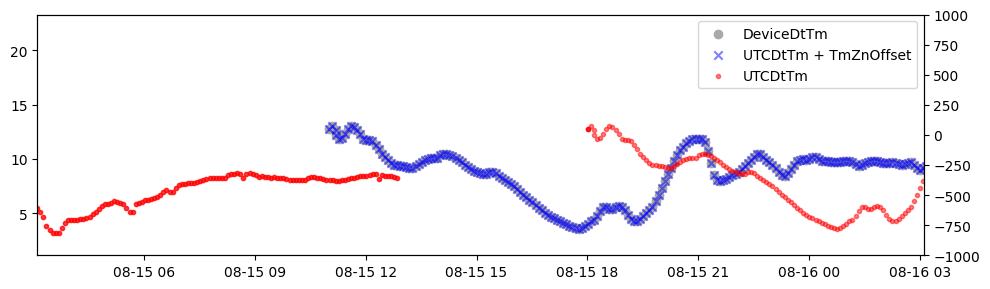

In [ ]:
#ploting a single patient's CGM data
pt_grps = df_cgm.groupby('PtID', observed=False)
subframe = pt_grps.get_group(1173).copy()
subframe['AdjustedDtTm'] = subframe.UTCDtTm + pd.to_timedelta(subframe.TmZnOffset, unit='minute')

temp = subframe.dropna(subset=['DeviceDtTm']).sort_values(['DeviceDtTm'])

fig, ax = plt.subplots(figsize=(10, 3)); twinx = ax.twinx()
offset=4.5

ax.scatter(temp.DeviceDtTm, temp.CGMVal, label='DeviceDtTm', marker='o',alpha=1, color='darkgray')
ax.scatter(temp.AdjustedDtTm, temp.CGMVal, label='UTCDtTm + TmZnOffset', marker='x', alpha=0.5,color='blue')

temp = subframe.dropna(subset=['UTCDtTm']).sort_values(['UTCDtTm'])
ax.scatter(temp.UTCDtTm, temp.CGMVal, label='UTCDtTm', marker='.',alpha=0.5,color='red')
twinx.plot(temp.UTCDtTm, temp.TmZnOffset, label='TmZnOffset')

ax.set_xlim(temp.UTCDtTm.min()+timedelta(days=offset), temp.UTCDtTm.min()+timedelta(days=offset+1))
twinx.set_ylim(-1000, 1000); ax.legend(); plt.tight_layout()
plt.show()
del subframe, temp

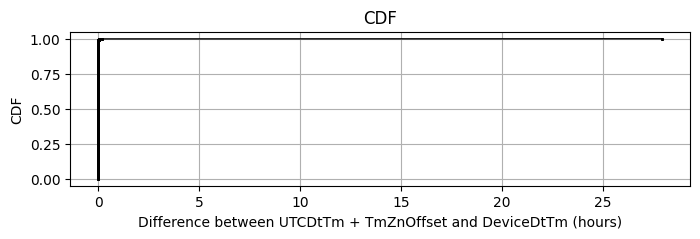

In [ ]:
# plot the difference between UTCDtTm + TmZnOffset and DeviceDtTm
temp = df_cgm.sample(10000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)

temp.loc[:,'Diff'] = (temp.DeviceDtTm - (temp.UTCDtTm + pd.to_timedelta(temp.TmZnOffset, unit='minute'))).dt.total_seconds()/3600

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(temp.Diff.abs(), xlabel='Difference between UTCDtTm + TmZnOffset and DeviceDtTm (hours)', ax=ax)

We see that By adjusting UTCDtTm with the offset we obtain DeviceDtTm

```DeviceDtTm = UTCDtTm + TmZnOffset```

This indicates that DeviceDtTm is local and UTCDtTm is in fact UTC and not time zone compensated as stated in the glossary. However, we can not rely on DeviceDtTm and TmZnOffset because it only exists for a fraction of the data. Therefore we need to rely on  UTCDtTm and convert it to local time (and we need to infer or extrapolate the TmZnOffset).

Before we do this we need to **confirm, once and for all if UTCDtTm column are really utc** because the glossary is raising some doubts. We do this by **plotting the distributions** of cgm values for both and compare. We do this using mean and std of rolling hour of day (centered). When we see clearly pronounced postprandial morning, lunch and dinner spikes, we know they are local.

(Note: We see that some differences are not equal to zero. In these cases, the time shift is a fraction of hours. We don't know why that is.)

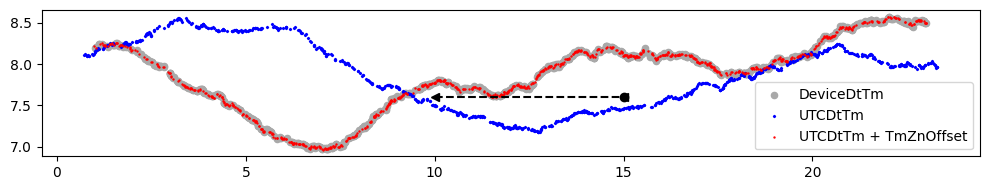

In [ ]:
#plot daytime average CGM values

#reduce data to those with values in both timestamp columns
temp = df_cgm.sample(100000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['datetime'] = pd.to_datetime(temp.UTCDtTm) + pd.to_timedelta(temp.TmZnOffset, unit='minute')

#calculate the hour of day for each timestamp
temp['DeviceDtTm_hod'] = temp.DeviceDtTm.dt.hour+temp.DeviceDtTm.dt.minute/60+temp.DeviceDtTm.dt.second/3600
temp['UTCDtTm_hod'] = temp.UTCDtTm.dt.hour+temp.UTCDtTm.dt.minute/60+temp.UTCDtTm.dt.second/3600
temp['datetime_hod'] = temp.datetime.dt.hour+temp.datetime.dt.minute/60+temp.datetime.dt.second/3600

#calcualte centered moving average
window = 2000
ma_DeviceDtTm  = temp[['CGMVal','DeviceDtTm_hod']].sort_values('DeviceDtTm_hod').rolling(window=window, min_periods=window, on='DeviceDtTm_hod', center=True).mean().sample(1000)
ma_UTCDtTm  = temp[['CGMVal','UTCDtTm_hod']].sort_values('UTCDtTm_hod').rolling(window=window, min_periods=window, on='UTCDtTm_hod', center=True).mean().sample(1000)
ma_datetime  = temp[['CGMVal','datetime_hod']].sort_values('datetime_hod').rolling(window=window, min_periods=window, on='datetime_hod', center=True).mean().sample(1000)

#draw
plt.figure(figsize=(10,2)); 
plt.scatter(ma_DeviceDtTm.DeviceDtTm_hod, ma_DeviceDtTm.CGMVal, label='DeviceDtTm', color='darkgray', marker='o',s=20)
plt.scatter(ma_UTCDtTm.UTCDtTm_hod, ma_UTCDtTm.CGMVal, label='UTCDtTm', color='blue', marker='x',s=2)
plt.scatter(ma_datetime.datetime_hod, ma_datetime.CGMVal, label='UTCDtTm + TmZnOffset', color='red', marker='.',s=2)

plt.plot([10,15],[7.6,7.6], color='black', linestyle='--', marker='<')
plt.plot([15],[7.6], color='black', marker='o')
plt.legend(); plt.tight_layout()


From this we can clearly see 
1. DeviceDtTm and the offset compensated utc aligns with expected diurnal, postprandial patterns (pronounced peak in the morning, noon and evening). 
2. Using UTC alone (blue), the peaks are less pronounced and roughly offset by 5 hours (black arrow) (At UTC 15:00 we see the morning peak, which really is at around 10:00 (-5h). This is in line with the fact that the majority of time zone offsets is around -300 minutes (-5hours). Note that just compensating UTC by 5 hours does not give the same pronounced peaks, since there are users with other offsets, the peaks are washed out.

Note: The glossary description is misleading.
> UTCDtTm : Device date and time (with timezone offset)  

### Which Offset to use?

One option would be to extrapolate the `TmZnOffset` (bfill/ffill)? To check if this is a viable option we check how many patients have TmZnOffset data.  We do this by checking the fraction of patients with at least one TmZnOffset value. 

37.18% of patients have at least one timezone offset


Text(0.5, 1.0, 'Availability of timezone offsets for patients with at least one')

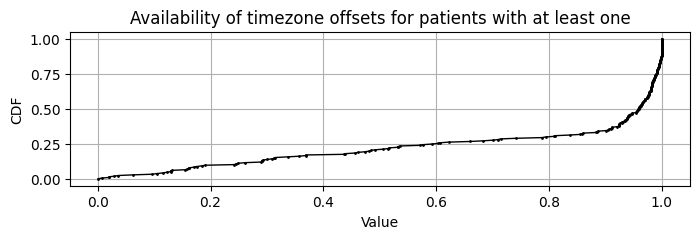

In [ ]:
#check fraction of patients with at least one timezone offset
frac = (df_cgm.groupby('PtID').TmZnOffset.count()>1).sum()/df_cgm.PtID.nunique()
print(f'{frac:.2%} of patients have at least one timezone offset')

#check fraction of non NaN offsets for patients with at least one
pts_with_data = df_cgm.dropna(subset=['TmZnOffset'] ).PtID.unique()
temp = df_cgm.loc[df_cgm.PtID.isin(pts_with_data)]
temp = temp.groupby('PtID').TmZnOffset.agg(lambda x: x.notna().mean())

plt.figure(figsize=(8,2)); ax = plt.gca()
cdf.plot_cdf(temp,ax=ax)
plt.title('Availability of timezone offsets for patients with at least one')

This is clearly not enough. 

#### Understand how often time zones change
Instead, (as JAEB mentioned) we could use the `PtTimezoneOffset` (utc offset in hours) from the patient roster. To understand if using this *static* value is acceptable, we need to understand  how often the actual timezone changes.

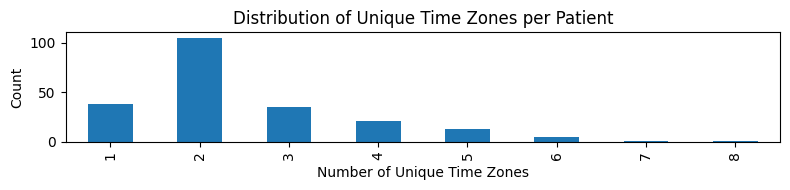

65.3% of patients have 2 unique time zones or less


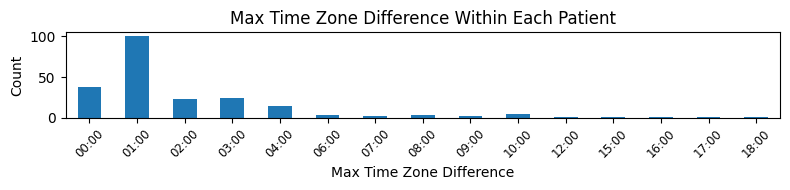

63.0% of patients have shifts of 1 hours or less


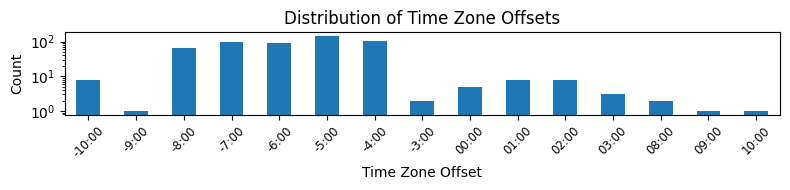

In [ ]:
#report time zone offsets and changes within patients
def timedetla_formatter(td):
    return f"{td.seconds // 3600 + td.days * 24:02d}:{(td.seconds % 3600) // 60:02d}"

#number of time zones per patient
number_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.nunique()
number_time_zones = number_time_zones.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
number_time_zones.plot(kind='bar', ax=ax)
plt.xlabel('Number of Unique Time Zones')
plt.ylabel('Count')
plt.title('Distribution of Unique Time Zones per Patient')
plt.tight_layout(); plt.show()

print(f'{100*number_time_zones.loc[0:2].sum()/number_time_zones.sum():2.1f}% of patients have 2 unique time zones or less')


#max difference within a patient
tzdiff_within = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.agg(lambda x: x.max()-x.min())
tzdiff_within = tzdiff_within.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
tzdiff_within.plot(kind='bar', ax=ax)
tick_labels = [timedetla_formatter(x) for x in tzdiff_within.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')
plt.xlabel('Max Time Zone Difference');plt.ylabel('Count')
plt.title('Max Time Zone Difference Within Each Patient')
plt.tight_layout();plt.show()

print(f'{100*tzdiff_within[tzdiff_within.index<=timedelta(hours=1)].sum()/tzdiff_within.sum():2.1f}% of patients have shifts of 1 hours or less')


#Which time zones exist?
all_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.unique().explode()
plt.figure(figsize=(8, 2)); ax=plt.gca()
all_time_zones= all_time_zones.value_counts().sort_index()
all_time_zones.plot(kind='bar', logy=True, ax=ax)
tick_labels = [timedetla_formatter(x) for x in all_time_zones.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')

plt.xticks(rotation=45, fontsize='small')
plt.xlabel('Time Zone Offset'); plt.ylabel('Count'); plt.title('Distribution of Time Zone Offsets')
plt.tight_layout();plt.show()

We see that 
 - Majority of most patients experience more than 1 time zones.
 - The majority is a change of 1 hour. Likely the result of daylight saving times. 
- But, a significant fraction experiences changes of 2,3 or 4 hours or more. This is nothing, that we could account for. While we can remove patients with more frequent changes in `TmZnOffset`, almost 2/3 of the patients have no data in that column. 

However, these time zone changes are likely infrequent as most patients will travel for short periods only. Let's estimate the expected error.

#### Estimate static time zone error

To estimate the error, we compare the static offsets from the patient roster with the device reported offsets for those user that have it.

In [ ]:
## obtaining local times from utc and patient roster offsets

# joining tables
df_patient['PtTimezoneOffset'] = pd.to_timedelta(df_patient.PtTimezoneOffset, unit='hour')
df_cgm = df_cgm.join(df_patient[['PtID','PtTimezoneOffset']].set_index('PtID'), on='PtID', how='left')

# converting to localized datetime
#method 1: getting localized datetimes (much slower)
#df_cgm['datetime'] = pd.to_datetime(df_cgm.UTCDtTm, utc=True)
#df_cgm['datetime'] = df_cgm.apply(lambda x: x.datetime.tz_convert(timezone(offset=x.PtTimezoneOffset)), axis=1)

#method 2: or as naive datetime (simply adding the offset)
df_cgm['datetime']= df_cgm.UTCDtTm+ df_cgm.TmZnOffset
#display(df_cgm.dropna(subset=['TmZnOffset']).sample(3))

5.3% of time zone differences are >2 hours


<=0       39.958037
<=1       94.671925
<=2       96.943519
<=3       98.296482
<=4       99.120356
<=inf    100.000000
Name: Cumulative Percentage, dtype: float64

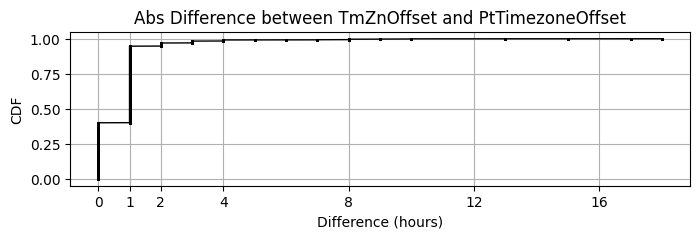

In [ ]:
#plotting the difference between CGM TmZnOffset and PtTimezoneOffset

diff = df_cgm.TmZnOffset - df_cgm.PtTimezoneOffset
diff = abs(diff.dropna().dt.total_seconds()/3600)

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(diff,ax=ax); plt.xlabel('Difference (hours)');
plt.title('Abs Difference between TmZnOffset and PtTimezoneOffset');
plt.xticks([0,1,2,4,8,12,16]); #plt.tight_layout(); plt.show()

#get cumulative stats
print(f'{(diff>=2).mean():.1%} of time zone differences are >2 hours')
error_counts = diff.value_counts(bins=[-1, 0, 1, 2, 3, 4, float('inf')], sort=False)
error_percentages = (error_counts / error_counts.sum()) * 100
error_percentages.name = 'Percentage'
cumsum_report = error_percentages.cumsum()
cumsum_report.name = 'Cumulative Percentage'
cumsum_report.index = [f'<={x.right:.0f}' for x in error_counts.index]
display(cumsum_report)

#### Conclusion
When using the static patient roster utc offset, the local time error will be <2 hours for >96% of the cases.

## Managing File Sizes

Processing patient data requires us to load all files into memory at once because the patient data is spread accross all CGM files. While we could use dask and load patient data iteratively, this would create a lot of overhead. Instead, we convert the data into a paquet format, splitting it by patient id. This allows us to process patients iteratively without requiring all data to be in memory making this a more preformant option overall.

In [6]:
from dask.distributed import Client
client = Client()
loop_paquet_path = os.path.join(raw_path, 'paquet', study_name) 

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 36.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52508,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: 3 minutes ago,Total memory: 36.00 GiB
Comm: tcp://127.0.0.1:52519,Total threads: 3
Dashboard: http://127.0.0.1:52521/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:52511,


In [ ]:
re_export = False

#Convert CSVs to parquet
if re_export:
    ddf = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM*.txt'), sep='|', 
                    parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                    usecols=['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'])
    ddf.to_parquet(os.path.join(loop_paquet_path,'cgm'), partition_on='PtID')

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50109 instead
  warnings.warn(


In [97]:
# Read parquet files into dask dataframe and perform operations without executing them

#read CGM files, partitioned by PtID
ddf = dd.read_parquet(os.path.join(loop_paquet_path,'cgm'), aggregate_files='PtID')
ddf = ddf.rename(columns={'PtID': 'patient_id', 'UTCDtTm': 'UTCDtTm', 'RecordType': 'RecordType', 'CGMVal': 'cgm'})
ddf = ddf.set_index('patient_id')#,drop=False) # make sure divisions are set correctly, keep patient_id as column

#drop calibrations
ddf = ddf.loc[ddf.RecordType == 'CGM']
ddf.index = ddf.index.astype('int') #a workaround to obmit error occuring when there were no rows left
ddf = ddf.drop(columns=['RecordType'])

#convert to mg/dL
ddf['cgm'] = ddf.cgm*18.018 

#convert utc to local datetime
#TODO: When i do not rename PTID here, then result = ddf.groupby(by='patient_id').apply(postprocessing.cgm_transform); result.loc[3].compute().head(10); 
# will fail with 'KeyError: 'patient_id' this is weird because ddf.index.name still yields patient_id
patient_roster = df_patient[['PtID','PtTimezoneOffset']].rename(columns={'PtID':'patient_id'}).set_index('patient_id')
ddf = ddf.join(patient_roster, how='left')
ddf['datetime'] = ddf.UTCDtTm + dd.to_timedelta(ddf.PtTimezoneOffset, unit='hour')
ddf = ddf.drop(columns=['UTCDtTm', 'PtTimezoneOffset'])

In [100]:
ddf.partitions[0:2]

,cgm,datetime
npartitions=2,,
3,float64,datetime64[ns]
4,...,...
5,...,...


### post process all CGM data using dask map_partition

In [19]:
import time

start_time = time.time()
meta={'datetime': 'datetime64[ns]', 'cgm': 'float64'}

#Method 1: using groupby: this works but only if we previously renamed the PtID of the patient roster index to 'patient_id' before the join
result = ddf.groupby(by='patient_id').apply(postprocessing.cgm_transform, meta=meta)
display(result.loc[3].compute().head(10))
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


start_time = time.time()
#Method 2: using map_partitions: this works but we loose the patient index, workaround:
def wrapper(df):
    assert df.index.nunique() == 1
    r= postprocessing.cgm_transform(df)
    r.assign('patient_id', df.index[0])
    
loop_cgm_transformed = ddf.map_partitions(postprocessing.cgm_transform, meta=meta)
transformed_partition = loop_cgm_transformed.get_partition(0).compute()
display(transformed_partition.head(10))
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

#this however, does not work: after doing map_partition, using .loc[3] returns only a single row
#loop_cgm_transformed = ddf.map_partitions(postprocessing.cgm_transform, meta=meta)
#transformed_partition = loop_cgm_transformed.loc[3].compute()
#display(transformed_partition.head(10))

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 14.16 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


datetime         cgm
patient_id                                  
3          0 2018-06-15 19:00:00  396.516721
           1 2018-06-15 19:05:00  394.273480
           2 2018-06-15 19:10:00  387.947360
           3 2018-06-15 19:15:00         NaN
           4 2018-06-15 19:20:00  338.812274
           5 2018-06-15 19:25:00  331.772641
           6 2018-06-15 19:30:00  325.617692
           7 2018-06-15 19:35:00         NaN
           8 2018-06-15 19:40:00  345.612267
           9 2018-06-15 19:45:00  351.902351

Execution time: 23.396004915237427 seconds


/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,datetime,cgm
0,2018-06-15 19:00:00,396.516721
1,2018-06-15 19:05:00,394.273480
2,2018-06-15 19:10:00,387.947360
3,2018-06-15 19:15:00,NaN
4,2018-06-15 19:20:00,338.812274
5,2018-06-15 19:25:00,331.772641
6,2018-06-15 19:30:00,325.617692
7,2018-06-15 19:35:00,NaN
8,2018-06-15 19:40:00,345.612267
9,2018-06-15 19:45:00,351.902351


Execution time: 1.8903381824493408 seconds


In [21]:
# export as CSV and parquet
# loop_parquet_out_path = os.path.join(out_path, 'parquet', study_name)
# loop_cgm_transformed.to_parquet(os.path.join(loop_parquet_out_path, 'cgm_transformed'))
# loop_cgm_transformed.to_csv(os.path.join(loop_parquet_out_path, 'cgm_transformed.csv'));

In [ ]:
ddf_basal = dd.read_parquet(os.path.join(loop_paquet_path, 'basal'), aggregate_files='PtID')
ddf_cgm = dd.read_parquet(os.path.join(loop_paquet_path, 'cgm'), aggregate_files='PtID')

ddf_basal = ddf_basal.set_index('PtID')
ddf_cgm = ddf_cgm.set_index('PtID')

In [ ]:

print('Basal')
report_duplicates(ddf_basal, ['UTCDtTm', 'PtID'], ['UTCDtTm'])
print('CGM')
report_duplicates(ddf_cgm, ['UTCDtTm', 'PtID'], ['UTCDtTm'])

Bolus
300879 duplicates (11.05%)
308982 duplicates (11.35%) ['UTCDtTm', 'PtID']


,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,ExpectedDuration,OriginName,PtID
425148,2018-10-14 11:08:08,normal,2.1,NaN,NaN,NaN,NaN,NaN,com.apple.HealthKit,3
70229,2018-10-14 11:08:08,normal,2.1,NaN,NaN,NaN,NaN,NaN,com.apple.HealthKit,3


Basal
108138 duplicates (0.22%)
220815 duplicates (0.46%) ['UTCDtTm', 'PtID']


,UTCDtTm,BasalType,Duration,ExpectedDuration,Percnt,Rate,SuprBasalType,SuprDuration,SuprRate,TmZnOffset,PtID


CGM


/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


19628647 duplicates (17.66%)


/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


21857113 duplicates (19.67%) ['UTCDtTm', 'PtID']


,UTCDtTm,RecordType,CGMVal,PtID
143914,2018-10-14 17:03:08,CGM,6.93843,3
143915,2018-10-14 17:03:08,CGM,6.93843,3


In [ ]:
# Example for duplciates on UTCDtTm which are not duplicates when considering all columns
first_partition = ddf_bolus.partitions[1].compute()
duplicates_subset = first_partition.duplicated(subset=['UTCDtTm'], keep=False)
duplicates_all = first_partition.duplicated(keep=False)

# Show rows that are duplicated based on PtID and UTCDtTm but not duplicated when considering all columns
unique_duplicates = duplicates_subset & ~duplicates_all

# Compute and display the result
df_unique_duplicates = first_partition[unique_duplicates]
display(df_unique_duplicates)

,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,Duration,ExpectedDuration,OriginName
PtID,,,,,,,,,
4,2019-01-10 01:22:31,normal,15.0,NaN,NaN,NaN,NaN,NaN,com.apple.HealthKit
4,2019-01-10 01:22:31,normal,9.2,NaN,NaN,NaN,NaN,NaN,com.apple.HealthKit


We see that there are instances where we have temporal duplicates with different values and it is unclear which one to trust.

In [ ]:
df_cgm_sample = ddf_cgm.sample(frac=0.1).compute().reset_index()

df_basal_sample = ddf_basal.sample(frac=0.1).compute().reset_index()

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 14.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 9.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


#### Null values

In [ ]:

print(df_basal_sample.columns)
print(df_cgm_sample.columns)

Index(['PtID', 'UTCDtTm', 'BolusType', 'Normal', 'ExpectedNormal', 'Extended',
       'ExpectedExtended', 'Duration', 'ExpectedDuration', 'OriginName'],
      dtype='object')
Index(['PtID', 'UTCDtTm', 'BasalType', 'Duration', 'ExpectedDuration',
       'Percnt', 'Rate', 'SuprBasalType', 'SuprDuration', 'SuprRate',
       'TmZnOffset'],
      dtype='object')
Index(['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'], dtype='object')


In [ ]:
#display the value counts
print('VALUE FRACTIONS:')
display(df_bolus_sample.value_counts(subset=['BolusType'])*100/len(df_bolus_sample))

display(df_basal_sample.value_counts(subset=['BasalType','SuprBasalType'])*100/len(df_basal_sample))

display(df_cgm_sample.value_counts(subset=['RecordType'])*100/len(df_cgm_sample))

#display the nan values
print('NAN FRACTIONS')
display(100*df_basal_sample.isna().sum()/len(df_basal_sample))
display(100*df_bolus_sample.isna().sum()/len(df_bolus_sample))
display(100*df_cgm_sample.isna().sum()/len(df_cgm_sample))

VALUE FRACTIONS:


BasalType  SuprBasalType
temp       scheduled        75.881427
suspend    scheduled         0.002225
           automated         0.000957
           temp              0.000645
Name: count, dtype: float64

BolusType  
normal         99.591468
dual/square     0.347625
square          0.060907
Name: count, dtype: float64

RecordType 
CGM            99.935672
Calibration     0.064328
Name: count, dtype: float64

NAN FRACTIONS


PtID                 0.000000
UTCDtTm              0.000000
BasalType            0.000000
Duration             0.000000
ExpectedDuration    99.899315
Percnt              99.914414
Rate                 0.037624
SuprBasalType       24.114746
SuprDuration        99.964830
SuprRate            24.114808
TmZnOffset          99.345848
dtype: float64

PtID                 0.000000
UTCDtTm              0.000000
BolusType            0.000000
Normal               0.060907
ExpectedNormal      99.596854
Extended            99.591468
ExpectedExtended    99.938679
Duration            99.591468
ExpectedDuration    99.938679
OriginName           6.094832
dtype: float64

PtID          0.0
UTCDtTm       0.0
RecordType    0.0
CGMVal        0.0
dtype: float64

let's read the whole dataframe with all columns to check why it could be Dual Wave Boluses. As we can see, tehre is no information that would allow us to understand where the extended part comes from. Maybe this is during open loop mode or initiated from the pump directly. 

## Boluses

In [152]:
#read bolus and data frame
df_bolus = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|', 
                        parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S');

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_88214/3481925287.py:2: DtypeWarning: Columns (3,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bolus = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBolus.txt'), sep='|',


### Duplicates

Let's check for duplicates. As we can see below, there are significant amount of duplicates. Potentially due to different imports. 

On further inspection of one example, we see that the two duplicated rows are completely identical (except for the record id). So, the data source is not the problem but probbaly the import.

Example from LoopDeviceBolus.txt
```
PtID|RecID|ParentLOOPDeviceUploadsID|DeviceDtTm|UTCDtTm|BolusType|Normal|ExpectedNormal|Extended|ExpectedExtended|Duration|ExpectedDuration|TmZnOffset|OriginName|OriginVers|OriginType|OriginDeviceFirmwrVer|OriginDeviceHardwrVer|OriginDeviceManufact|OriginDeviceModel|OriginOperatingSystVer|OriginProductType
3|1799993|1300475||2018-10-14 11:08:08|normal|2.10|||||||com.apple.HealthKit|55|service|2.7.0||Insulet|Eros|12.2.0|iPhone10,4
3|497101|1300475||2018-10-14 11:08:08|normal|2.10|||||||com.apple.HealthKit|55|service|2.7.0||Insulet|Eros|12.2.0|iPhone10,4
```

In [ ]:
def report_duplicates(df, subset, sort_by):    
    num_duplicated = df.duplicated().sum()
    print(f'{num_duplicated} duplicates ({100*num_duplicated/len(df):.2f}%)')

    num_duplicated = df.duplicated(subset=subset).sum()
    print(f'{num_duplicated} duplicates ({100*num_duplicated/len(df):.2f}%) {subset}')

    bDuplicated = df.duplicated(keep=False)
    display(df[bDuplicated].sort_values(sort_by).head(2))

    

report_duplicates(df_bolus, ['UTCDtTm', 'PtID'], ['UTCDtTm'])

0 duplicates (0.00%)
308982 duplicates (11.35%) ['UTCDtTm', 'PtID']


,PtID,RecID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,ExpectedNormal,Extended,ExpectedExtended,...,TmZnOffset,OriginName,OriginVers,OriginType,OriginDeviceFirmwrVer,OriginDeviceHardwrVer,OriginDeviceManufact,OriginDeviceModel,OriginOperatingSystVer,OriginProductType


### NaN values

In [ ]:
#print stats for bolus dataframe
print('COLUMNS:')
print(df_bolus.columns)

#display the value counts
print('VALUE FRACTIONS:')
display(df_bolus.value_counts(subset=['BolusType'])*100/len(df_bolus))

#display the nan values
print('NAN FRACTIONS')
display(100*df_bolus.isna().sum()/len(df_bolus))

print('DUPLICATES:')
report_duplicates(df_bolus, ['UTCDtTm', 'PtID'], ['UTCDtTm'])

COLUMNS:
Index(['PtID', 'RecID', 'ParentLOOPDeviceUploadsID', 'DeviceDtTm', 'UTCDtTm',
       'BolusType', 'Normal', 'ExpectedNormal', 'Extended', 'ExpectedExtended',
       'Duration', 'ExpectedDuration', 'TmZnOffset', 'OriginName',
       'OriginVers', 'OriginType', 'OriginDeviceFirmwrVer',
       'OriginDeviceHardwrVer', 'OriginDeviceManufact', 'OriginDeviceModel',
       'OriginOperatingSystVer', 'OriginProductType'],
      dtype='object')
VALUE FRACTIONS:


BolusType  
normal         99.615245
dual/square     0.326720
square          0.058035
Name: count, dtype: float64

NAN FRACTIONS


PtID                          0.000000
RecID                         0.000000
ParentLOOPDeviceUploadsID     0.000000
DeviceDtTm                   94.315252
UTCDtTm                       0.000000
BolusType                     0.000000
Normal                        0.058035
ExpectedNormal               99.498294
Extended                     99.615245
ExpectedExtended             99.933664
Duration                     99.615245
ExpectedDuration             99.933664
TmZnOffset                   94.315252
OriginName                    5.684748
OriginVers                    5.684858
OriginType                    5.684748
OriginDeviceFirmwrVer        10.654054
OriginDeviceHardwrVer        99.912875
OriginDeviceManufact          7.744095
OriginDeviceModel             7.744095
OriginOperatingSystVer        5.684748
OriginProductType             5.684748
dtype: float64

In [148]:
#print the fraction of extended boluses
print(f'{100*df_bolus.Extended.notna().mean():.2f}% of boluses are extended')
print(f'In {(df_bolus.Extended.notna() == df_bolus.Duration.notna()).mean():.1%} of all rows, it is either extended and duration are filled or neither')
display(df_bolus.loc[df_bolus.Extended.notna()].head(3).dropna(axis=1,how='all'))

0.38% of boluses are extended
In 100.0% of all rows, it is either extended and duration are filled or neither


,PtID,RecID,ParentLOOPDeviceUploadsID,DeviceDtTm,UTCDtTm,BolusType,Normal,Extended,Duration,TmZnOffset
31932,982,53838,335722,2018-10-28 19:06:49,2018-10-29 00:06:49,dual/square,7.5,3.2,9900000.0,-300.0
31942,982,53848,335722,2018-11-11 18:07:34,2018-11-11 23:07:34,dual/square,4.8,5.9,9000000.0,-300.0
32305,982,54211,335723,2018-09-30 20:13:16,2018-10-01 00:13:16,dual/square,6.8,4.6,7200000.0,-240.0


In [149]:
# Example how to concatenate the normal and extended boluses
data = {
    "Datetime": ["2024-01-01 00:00", "2024-01-01 01:00", "2024-01-01 02:00"],
    "Normal": [10, 15, 20],
    "Extended": [np.NaN, 5, np.NaN],
    "Duration": [np.NaN, 30, np.NaN]
}
df = pd.DataFrame(data)
df["Datetime"] = pd.to_datetime(df["Datetime"])

normal = df[["Datetime", "Normal"]]
normal.loc[:,'Duration'] = 0

extended = df.dropna(subset=['Extended'])[["Datetime", "Extended", 'Duration']].rename(columns={"Extended": "Normal"})

pd.concat([normal, extended], axis=0).sort_values('Datetime')


/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_88214/530583255.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal.loc[:,'Duration'] = 0


,Datetime,Normal,Duration
0,2024-01-01 00:00:00,10.0,0.0
1,2024-01-01 01:00:00,15.0,0.0
1,2024-01-01 01:00:00,5.0,30.0
2,2024-01-01 02:00:00,20.0,0.0


## Basal

In [ ]:
#example for duplicates in boluses
def report_duplicates(ddf, subset, sort_by):    
    num_duplicated = ddf.map_partitions(lambda x: x.duplicated().sum()).compute().sum()
    print(f'{num_duplicated} duplicates ({100*num_duplicated/len(ddf):.2f}%)')

    num_duplicated = ddf.map_partitions(lambda x: x.duplicated(subset=subset).sum()).compute().sum()
    print(f'{num_duplicated} duplicates ({100*num_duplicated/len(ddf):.2f}%) {subset}')

    df = ddf.partitions[0].compute()
    bDuplicated = df.duplicated(keep=False)
    display(df[bDuplicated].sort_values(sort_by).head(2))

print('Bolus')
report_duplicates(ddf_bolus, ['UTCDtTm', 'PtID'], ['UTCDtTm'])

In [ ]:
# Basal to parquet
basal_columns = ['PtID', 'UTCDtTm', 'BasalType', 'Duration', 'ExpectedDuration', 'Percnt', 'Rate', 'SuprBasalType', 'SuprDuration', 'SuprRate', 'TmZnOffset']
ddf_basal = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceBasal*.txt'), sep='|', 
                        parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                        usecols=basal_columns)
ddf_basal.to_parquet(os.path.join(loop_paquet_path, 'basal'), partition_on='PtID')

Todos:
Check if Datetime+duration > next Datetime --> 

## CGM

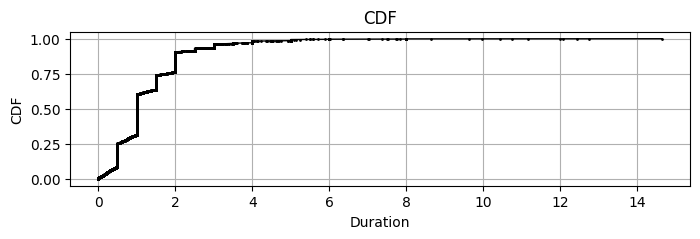

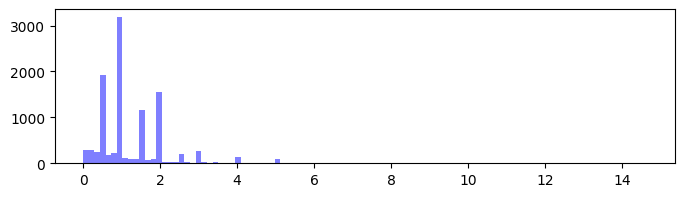

In [92]:
durations = df_bolus.Duration.dropna().values/(1000*3600)
plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(durations, xlabel='Duration',ax=ax)
plt.figure(figsize=(8, 2)); ax = plt.gca()
ax.hist(durations, bins=100, alpha=0.5, color='blue');

Now we know that Duration is the extended bolus duration. We need to split the row in an immediate and a extended part.
We could do this efficiently by just creating new rows for the Extended parts.

#### Special CGM Values

Let's check on CGM distribution. As we can see below, 0 and 400 CGM values are capped (as expected) but no 0 values exist.

Number of values around 0: 0


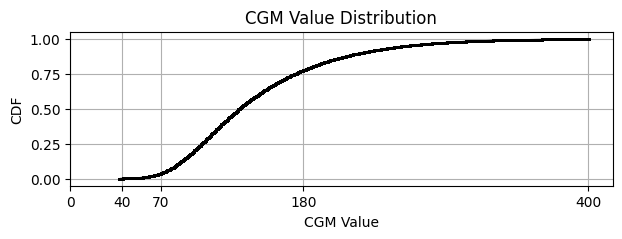

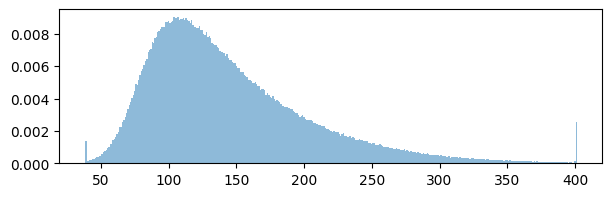

In [ ]:
#Visualize CGM Distribution
R = ddf_cgm.map_partitions(lambda x: x.CGMVal.sample(n=min(1000,len(x)))).compute()
print(f"Number of values around 0: {((R<1) & (R>-1)).sum()}")
plt.figure(figsize=(7, 2)); ax = plt.gca()
cdf.plot_cdf(R*18, xlabel='CGM Value', ylabel='CDF', title='CGM Value Distribution',ax=ax)
plt.xticks([0,40,70,180,400]);

plt.figure(figsize=(7, 2)); ax = plt.gca()
vc = (R*18).round().value_counts(normalize=True).sort_index()
plt.bar(vc.index,vc.values, width=1, alpha=0.5);

NameError: name 'ddf' is not defined

## Test Class

In [ ]:
import os, sys
sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from studies import loop
from studies.studydataset import StudyDataset
from dask.distributed import Client
#client = Client()
import importlib
importlib.reload(loop)

#get the file path
study: StudyDataset = loop.Loop(study_path=os.path.join(os.getcwd(), '..', 'data', 'raw', 'Loop study public dataset 2023-01-31'))
r = study.extract_cgm_history()
memory_size = r.memory_usage().sum() / 1024**2
print(f"Memory size of r: {memory_size:.2f} MB");
